In [12]:
from utils import read_data

data = read_data(keep_nan=True,keep_dates=False)
df_all = data.train_val_df
df_test = data.test_df
df_all = df_all.drop(columns=["station","time_stamp"])
df_test = df_test.drop(columns=["station","time_stamp"])
df_all.columns
df_all.head(10)

Loaded  data\PRSA_Data_Aotizhongxin_20130301-20170228.csv
Loaded  data\PRSA_Data_Changping_20130301-20170228.csv
Loaded  data\PRSA_Data_Dingling_20130301-20170228.csv
Loaded  data\PRSA_Data_Dongsi_20130301-20170228.csv
Loaded  data\PRSA_Data_Guanyuan_20130301-20170228.csv
Loaded  data\PRSA_Data_Gucheng_20130301-20170228.csv
Loaded  data\PRSA_Data_Huairou_20130301-20170228.csv
Loaded  data\PRSA_Data_Nongzhanguan_20130301-20170228.csv
Loaded  data\PRSA_Data_Shunyi_20130301-20170228.csv
Loaded  data\PRSA_Data_Tiantan_20130301-20170228.csv
Loaded  data\PRSA_Data_Wanliu_20130301-20170228.csv
Loaded  data\PRSA_Data_Wanshouxigong_20130301-20170228.csv
Applied normalization on  ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
Applied normalization on  ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,WD_NNW,WD_NW,WD_S,WD_SE,WD_SSE,WD_SSW,WD_SW,WD_W,WD_WNW,WD_WSW
0,4.0,0.002006,0.007433,0.020671,0.020202,0.071710,0.312195,0.672185,0.339310,0.0,...,1,0,0,0,0,0,0,0,0,0
1,8.0,0.006018,0.007433,0.020671,0.020202,0.071710,0.305691,0.675497,0.347586,0.0,...,0,0,0,0,0,0,0,0,0,0
2,7.0,0.005015,0.009434,0.031053,0.020202,0.067974,0.305691,0.680464,0.347586,0.0,...,1,0,0,0,0,0,0,0,0,0
3,6.0,0.004012,0.021441,0.034514,0.020202,0.067040,0.300813,0.697020,0.331034,0.0,...,0,1,0,0,0,0,0,0,0,0
4,3.0,0.001003,0.023442,0.037974,0.020202,0.067040,0.291057,0.708609,0.329655,0.0,...,0,0,0,0,0,0,0,0,0,0
5,5.0,0.003009,0.035449,0.058737,0.030303,0.061437,0.287805,0.715232,0.328276,0.0,...,0,0,0,0,0,0,0,0,0,0
6,3.0,0.001003,0.035449,0.107185,0.040404,0.046495,0.281301,0.730132,0.335172,0.0,...,0,0,0,0,0,0,0,0,0,0
7,3.0,0.004012,0.037450,0.138329,0.040404,0.039957,0.297561,0.745033,0.335172,0.0,...,1,0,0,0,0,0,0,0,0,0
8,3.0,0.004012,0.031447,0.145250,0.040404,0.041825,0.325203,0.759934,0.333793,0.0,...,1,0,0,0,0,0,0,0,0,0
9,3.0,0.006018,0.023442,0.093342,0.030303,0.054900,0.343089,0.763245,0.332414,0.0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
import numpy as np
data = df_all.values.reshape(12,-1,27)[:,-29760:,:]
data = data.reshape(-1 ,48,27)
data = data[~np.isnan(data).any(axis=(1,2))]
print(data.shape)

(2985, 48, 27)


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as tud

class TimeSeriesDataset(tud.Dataset):
    def __init__(self, data):
        self.y = data[:,24:,0]
        self.x = data[:,:,1:]
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.y[idx], self.x[idx]

In [15]:
class LSTM_Model(nn.Module):
    def __init__(self):
        super(LSTM_Model, self).__init__()
        self.LSTM = nn.LSTM(26, 16, batch_first=True)
        self.fc1 = nn.Linear(16, 5)
        self.fc2 = nn.Linear(5 ,1)
        
    def forward(self, x):
        x, (h_n, h_c) = self.LSTM(x)
        x = x[:,24:,:]
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p = 0.1, training = self.training)
        x = self.fc2(x)
        return x

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 1e-3
batch_size = 30
epochs = 80
test_interval = 5
log_interval = 50

model = LSTM_Model().to(device).double()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
dataset = TimeSeriesDataset(data)
train_set, validation_set = torch.utils.data.random_split(dataset, [len(dataset) - 590, 590])
train_dataloader = tud.DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_dataloader = tud.DataLoader(validation_set, batch_size=batch_size)

In [17]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    
    losses = []
    for batch_idx, (y ,x) in enumerate(train_loader):
        y = y.to(device)
        x = x.to(device)
        
        optimizer.zero_grad()
        output = model(x)
        
        loss = F.mse_loss(output, y.view(-1,24,1))
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, (batch_idx + 1) * batch_size, len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))
    return losses

In [18]:
def test(model, device, test_loader):
    model.eval()
    losses = []
    accuracy10 = []
    accuracy15 = []
    accuracy20 = []
    for batch_idx, (y ,x) in enumerate(test_loader):
        y = y.to(device).view(-1,24,1)
        x = x.to(device)
        
        with torch.no_grad():
            output = model(x)
            loss = F.mse_loss(output, y)
            losses.append(loss.item())
            diff = output - y
            accuracy10.append(len(diff[abs(diff)<=10]))
            accuracy15.append(len(diff[abs(diff)<=15]))
            accuracy20.append(len(diff[abs(diff)<=20]))
    data_size = len(test_loader.dataset) * 24.
    print(float(sum(losses))/len(losses), float(sum(accuracy10))/data_size, float(sum(accuracy15))/data_size,
          float(sum(accuracy20))/data_size)
    return float(sum(losses))/len(losses), float(sum(accuracy10))/data_size, \
           float(sum(accuracy15))/data_size, float(sum(accuracy20))/data_size

In [19]:
epoch_losses = []
epoch_test_losses = []
epoch_test_acc10 = []
epoch_test_acc15 = []
epoch_test_acc20 = []
for epoch in range(epochs):
    loss = train(model, device, train_dataloader, optimizer, epoch, log_interval)
    epoch_losses.append(loss)
    test_losses, acc10, acc15, acc20 = test(model, device, validation_dataloader)
    epoch_test_losses.append(test_losses)
    epoch_test_acc10.append(acc10)
    epoch_test_acc15.append(acc15)
    epoch_test_acc20.append(acc20)
    

Train Epoch: 1 [1500/2395 (62%)]	Loss: 8689.731783
11132.748400853523 0.1047316384180791 0.1701271186440678 0.22620056497175142
Train Epoch: 2 [1500/2395 (62%)]	Loss: 10092.153724
10627.534213057981 0.1468220338983051 0.20466101694915254 0.2554378531073446
Train Epoch: 3 [1500/2395 (62%)]	Loss: 15535.255105
9954.551049187612 0.20466101694915254 0.2554378531073446 0.3001412429378531
Train Epoch: 4 [1500/2395 (62%)]	Loss: 10272.624054
9173.25402621925 0.23375706214689265 0.30995762711864405 0.35353107344632767
Train Epoch: 5 [1500/2395 (62%)]	Loss: 8174.619743
8348.173006247067 0.21235875706214688 0.32125706214689265 0.4088276836158192
Train Epoch: 6 [1500/2395 (62%)]	Loss: 8172.034168
7549.364925871702 0.18093220338983051 0.2747175141242938 0.37662429378531076
Train Epoch: 7 [1500/2395 (62%)]	Loss: 8105.831221
6842.373788142836 0.15932203389830507 0.23495762711864407 0.3219632768361582
Train Epoch: 8 [1500/2395 (62%)]	Loss: 10273.951742
6265.251845426388 0.13637005649717515 0.2117937853

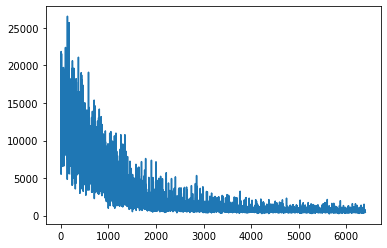

In [20]:
import matplotlib.pyplot as plt
A = np.array(epoch_losses)
plt.plot(A.flatten())

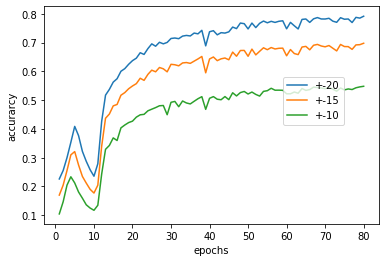

In [21]:
B = np.array(epoch_test_acc20)
C = np.array(epoch_test_acc15)
D = np.array(epoch_test_acc10)
x = range(1,81)
plt.plot(x, B.flatten(), label = "+-20")
plt.plot(x, C.flatten(), label = "+-15")
plt.plot(x, D.flatten(), label = "+-10")
plt.xlabel('epochs')
plt.ylabel('accurarcy')
plt.legend(bbox_to_anchor=(0.7, 0.7))
plt.show()

In [22]:
#inference on test data
test_data = df_test.values.reshape(12,-1,27)[:,-5232:,:]
test_data = test_data.reshape(-1 ,48,27)
test_data = test_data[~np.isnan(test_data).any(axis=(1,2))]
print(test_data.shape)
test_set = TimeSeriesDataset(test_data)
test_dataloader = tud.DataLoader(test_set, batch_size=batch_size)

(594, 48, 27)


In [23]:
test_losses, acc10, acc15, acc20 = test(model, device, test_dataloader)

588.0120628057017 0.5611672278338945 0.6889029180695847 0.7716049382716049
